<a href="https://colab.research.google.com/github/agt7/dev/blob/master/4_1_bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# パッケージのインポート
import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# ε-greedyの計算処理の作成
class EpsilonGreedy():
    # ε-greedyの計算処理の初期化
    def __init__(self, epsilon):
        self.epsilon = epsilon # 探索する確率

    # 試行回数と価値のリセット
    def initialize(self, n_arms):
        self.n = np.zeros(n_arms) # 各アームの試行回数
        self.v = np.zeros(n_arms) # 各アームの価値

    # アームの選択
    def select_arm(self):
        if self.epsilon > random.random():
            # ランダムにアームを選択
            return np.random.randint(0, len(self.v))
        else:
            # 価値が高いアームを選択
            return np.argmax(self.v)

    # アルゴリズムのパラメータの更新
    def update(self, chosen_arm, reward, t):
        # 選択したアームの試行回数に1加算
        self.n[chosen_arm] += 1

        # 選択したアームの価値の更新
        n = self.n[chosen_arm]
        v = self.v[chosen_arm]
        self.v[chosen_arm] = ((n-1) / float(n)) * v + (1 / float(n)) * reward

    # 文字列情報の取得
    def label(self):
        return 'ε-greedy('+str(self.epsilon)+')'

In [ ]:
# UCB1アルゴリズム
class UCB1():
    # 試行回数と成功回数と価値のリセット
    def initialize(self, n_arms): 
        self.n = np.zeros(n_arms) # 各アームの試行回数
        self.w = np.zeros(n_arms) # 各アームの成功回数
        self.v = np.zeros(n_arms) # 各アームの価値
    
    # アームの選択
    def select_arm(self):
        # nが全て1以上になるようにアームを選択
        for i in range(len(self.n)):
            if self.n[i] == 0:
                return i
        
        # 価値が高いアームを選択
        return np.argmax(self.v)
        
    # アルゴリズムのパラメータの更新
    def update(self, chosen_arm, reward, ｔ):
        # 選択したアームの試行回数に1加算
        self.n[chosen_arm] += 1

        # 成功時は選択したアームの成功回数に1加算
        if reward == 1.0:
            self.w[chosen_arm] += 1
        
        # 試行回数が0のアームの存在時は価値を更新しない
        for i in range(len(self.n)):
            if self.n[i] == 0:
                return
        
        # 各アームの価値の更新
        for i in range(len(self.v)):
            self.v[i] = self.w[i] / self.n[i] + (2 * math.log(t) / self.n[i]) ** 0.5
        
    # 文字列情報の取得
    def label(self):
        return 'ucb1'

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# シミュレーションの実行
def play(algo, arms, num_sims, num_time):
    # 履歴の準備
    times = np.zeros(num_sims * num_time) # ゲーム回数の何回目か
    rewards = np.zeros(num_sims * num_time) # 報酬

    # シミュレーション回数分ループ
    for sim in range(num_sims):
        algo.initialize(len(arms)) # アルゴリズム設定の初期化

        # ゲーム回数分ループ
        for time in range(num_time):
            # インデックスの計算
            index = sim * num_time + time

            # 履歴の計算
            times[index] = time+1
            chosen_arm = algo.select_arm()
            reward = arms[chosen_arm].draw()
            rewards[index] = reward

            # アルゴリズムのパラメータの更新
            algo.update(chosen_arm, reward, time+1)

    # [ゲーム回数の何回目か, 報酬]
    return [times, rewards]

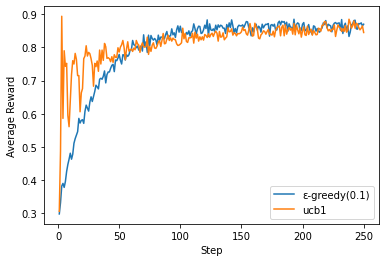

In [8]:
# アームの準備
arms = (SlotArm(0.3), SlotArm(0.5), SlotArm(0.9))

# アルゴリズムの準備
algos = (EpsilonGreedy(0.1),  UCB1())

for algo in algos:
    # シミュレーションの実行
    results = play(algo, arms, 1000, 250)
    
    # グラフの表示
    df = pd.DataFrame({'times': results[0], 'rewards': results[1]})
    mean = df['rewards'].groupby(df['times']).mean()
    plt.plot(mean, label=algo.label()) 

# グラフの表示
plt.xlabel('Step')
plt.ylabel('Average Reward')
plt.legend(loc='best')
plt.show()

In [ ]:
# スロットのアームの作成
class SlotArm():
    # スロットのアームの初期化
    def __init__(self, p):
        self.p = p # コインが出る確率

    # アームを選択した時の報酬の取得
    def draw(self):
        if self.p > random.random() :
            return 1.0
        else:
            return 0.0